In [31]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import normaltest
from statannotations.Annotator import Annotator

In [51]:
our_color_palette = {"WT": "#F2C14E", # yellow
                     "W": "#F2C14E", # yellow
                     "IP": "#79ADDC", # blue
                     "I": "#79ADDC", # blue
                     "KO": "#B279A7", # purple
                     "K": "#B279A7", # purple
                    } 
treatments_list = ["W", "I", "K"]
passages_list = ["p1", "p2", "p3", "p5", "p10"]
replicates_list = ['a', 'b', 'c']

In [52]:
# define protein 

proteins = {
    "1A": (709, 1206),
    "2A": (1207, 1278),
    "2B": (1279, 1692),
    "2C": (1693, 2925),
    "3A": (2926, 3361),
    "3B": (3364, 3432),
    "3C": (3433, 4368),
    "RdRp": (4369, 6022),
    "VP1": (6217, 7065),
    "VP4": (7066, 7236),
    "VP2": (7237, 8121),
    "VP3": (8122, 8902),
           }

In [76]:
# load diveristy 

fname = "all_snpgenie_codon_results.csv"
df = pd.read_csv(fname)

df = df[df['virus']=='CrPV']

df['genotype'] = df['passage'].str.split("_").str[0]
df['rep'] = df['passage'].str.split("_").str[-1]
df['passage'] = df['passage'].str.split("_").str[1].str.split("p").str[-1].astype(int)

## Compute pi_S and pi_N per protein


In [78]:
# per codon measurement

# piS: The mean number of pairwise synonymous differences per synonymous site in this product.
df['piS'] = df['S_diffs']/df['S_sites']

# piN: The mean number of pairwise nonsynonymous differences per nonsynonymous site in this product.
df['piN'] = df['N_diffs']/df['N_sites']

In [79]:
df = df[['site', 'codon', 'genotype', 'rep', 'passage', 'piS', 'piN']]

In [80]:
df_pis_protein = pd.DataFrame() 

for genotype in ['W', 'K', 'I']:
    for passage in [1,2,3,5,10]:
        for replicate in ['a', 'b', 'c']:
            for protein in proteins.items():
                protein_id = protein[0]
                protein_start = protein[1][0]
                protein_end = protein[1][1]
                protein_length = protein_end - protein_start

                df_temp = df[df['genotype']== genotype]
                df_temp = df_temp[df_temp['passage']==passage]
                df_temp = df_temp[df_temp['rep']==replicate]
                df_temp = df_temp[df_temp['site'].isin(list(range(protein_start,protein_end+1 )))]

                mean_pis = {
                            'genotype': [genotype], 
                            'passage': passage, 
                            'rep': replicate,
                            'protein': protein_id,
                            'piN': df_temp['piN'].sum()/protein_length/3, 
                            'piS': df_temp['piS'].sum()/protein_length/3, 
                            'piN-piS': df_temp['piN'].sum()/protein_length - df_temp['piS'].sum()/protein_length/3,
                        }
                df_pis_protein = pd.concat([df_pis_protein, pd.DataFrame(data=mean_pis)])

In [81]:
# make dataframe long

df_pis_protein_long = df_pis_protein.drop(["piN-piS"], axis=1)

df_pis_protein_long= pd.wide_to_long(df_pis_protein_long, 
                                      stubnames="pi",
                                      i=["genotype", "passage", "rep", "protein"],
                                      j="type",
                                      suffix="\D+",)
df_pis_protein_long = df_pis_protein_long.reset_index()

In [83]:
df_sns = pd.DataFrame() 

for genotype in ['W', 'K', 'I']:
    for passage in [1,2,3,5,10]:
        for protein in list(proteins.keys()):
            
            # query relevant rows
            df_temp = df_pis_protein[df_pis_protein['genotype']== genotype]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['protein']==protein]

            for replicate in ['a', 'b', 'c']:
                tmp_dict = {
                    "genotype": [genotype], 
                    'passage': passage, 
                    'protein': protein,
                    'rep': replicate, 
                    'value': df_temp[df_temp['rep']==replicate]["piN"].values, 
                    'measure': "piN", 
                }
                df_sns = pd.concat([df_sns, pd.DataFrame(data=tmp_dict)])
                
                tmp_dict = {
                    "genotype": [genotype], 
                    'passage': passage, 
                    'protein': protein,
                    'rep': replicate, 
                    'measure': "piS", 
                    'value': df_temp[df_temp['rep']==replicate]["piS"].values, 
                }
                df_sns = pd.concat([df_sns, pd.DataFrame(data=tmp_dict)])



In [85]:
df_p_value = pd.DataFrame() 

for genotype in ['W', 'K', 'I']:
    for passage in [1,2,3,5,10]:
        for protein in list(proteins.keys()) + ["Full_genome"]:
            
            # query relevant rows
            df_temp = df_pis_protein[df_pis_protein['genotype']== genotype]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['protein']==protein]
            
            pi_N = df_temp["piN"].values
            pi_S = df_temp["piS"].values
            
            tmp_dict = {
                "genotype": [genotype], 
                'passage': passage, 
                'protein': protein,
                'mean_piN': np.mean(pi_N), 
                'mean_piS': np.mean(pi_S), 
                'mean_piN-mean_piS': np.mean(pi_N) - np.mean(pi_S), 
                'piN/piS': np.mean(pi_N)/np.mean(pi_S), 
                'sem_piN': stats.sem(pi_N),
                'sem_piS': stats.sem(pi_S),
            }
            df_p_value = pd.concat([df_p_value, pd.DataFrame(data=tmp_dict)])



/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_56816/1414475028.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  'piN/piS': np.mean(pi_N)/np.mean(pi_S),
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lfuhrmann/Library/Pytho

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/dw/8dl4p6h53cgcmk

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_56816/2379505945.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.pointplot(
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_56816/2379505945.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.pointplot(
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_56816/2379505945.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.pointplot(
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_56816/2379505945.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.pointplot(
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_56816/2379505

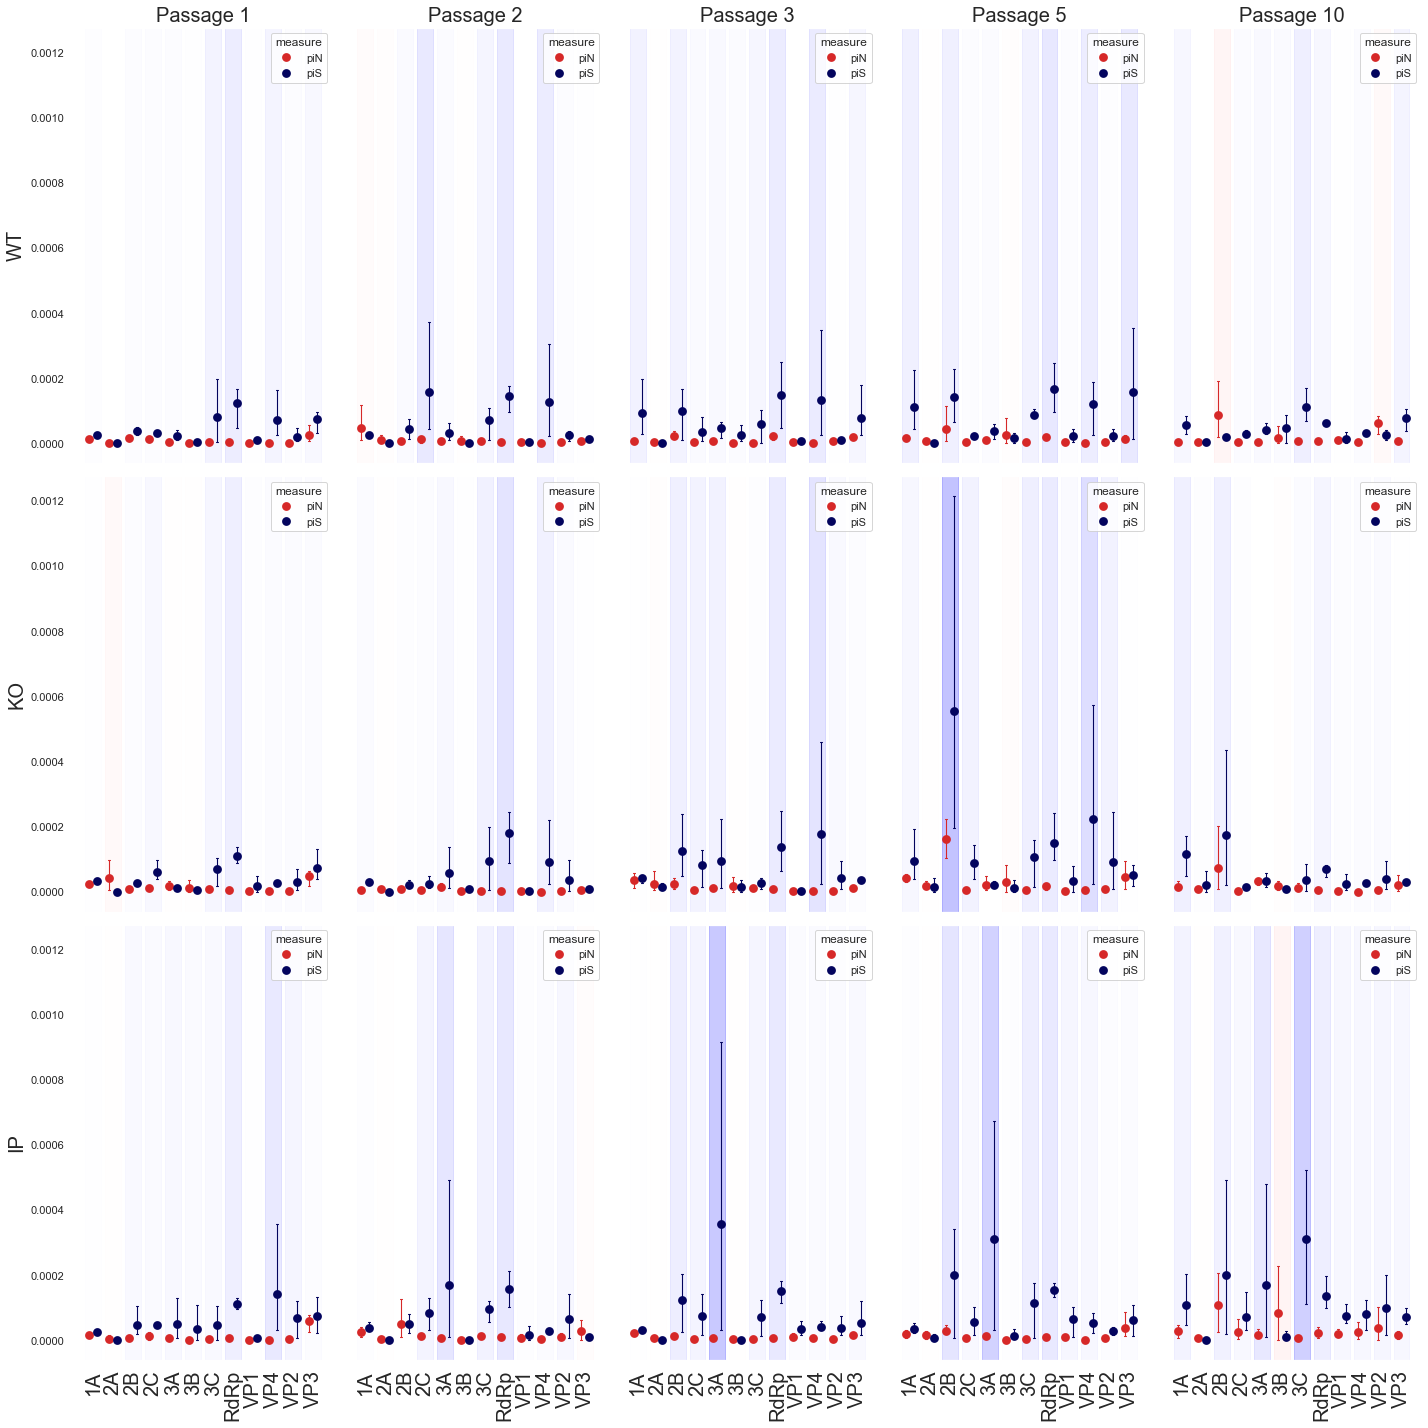

In [92]:
fig, ax = plt.subplots(3,5, sharex=True, sharey=True, figsize=(20,20))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

for idx_passage, passage in enumerate([1,2,3,5,10]):
    df_temp = df_sns[df_sns["passage"]==passage]
    for idx_genotype, genotype in enumerate(['W', 'K', 'I']):
        
        data = df_temp[df_temp["genotype"]==genotype]
        sns.pointplot(
            ax=ax[idx_genotype][idx_passage],
            data=data, 
            markers='o', 
            linestyles='',
            x="protein", 
            y='value', 
            hue ='measure', 
            errorbar=('ci', 95),
            hue_order=["piN", "piS"], 
            errwidth=1.1, 
            capsize=0.1,
            order=proteins.keys(), 
            palette=['#d62828', '#03045e'],
            dodge=0.4, 
            #log_scale=True, 
        )
        ax[idx_genotype][idx_passage].set_xlabel("")
        ax[idx_genotype][idx_passage].set_ylabel("")


        #ax[idx_genotype][idx_passage].set_ylim(0,0.00042)
        
        # shade background to show positive or negative selection
        df_direction_selection = df_p_value[df_p_value["passage"]==passage]
        df_direction_selection = df_direction_selection[df_direction_selection["genotype"]==genotype]
        
        for idx_protein, protein in enumerate(proteins.keys()):  
            piN_minus_piS = df_direction_selection[df_direction_selection["protein"]==protein]["mean_piN-mean_piS"].values[0]
            if piN_minus_piS > 0: # positive selection 
                color = 'red'
                alpha = np.abs(piN_minus_piS)*600
            elif piN_minus_piS < 0: # negative selection 
                color='blue'
                alpha = np.abs(piN_minus_piS)*600
            elif piN_minus_piS == 0.0:
                color='white'
                alpha = np.abs(piN_minus_piS)*600
            
            ax[idx_genotype][idx_passage].axvspan(xmin=idx_protein-0.4, xmax=idx_protein+0.4, color=color, alpha=alpha)

ax[2][0].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][1].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][2].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][3].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][4].tick_params(axis='x', rotation=90, labelsize = 20)

ax[0][0].set_title("Passage 1", fontsize=20)
ax[0][1].set_title("Passage 2", fontsize=20)
ax[0][2].set_title("Passage 3", fontsize=20)
ax[0][3].set_title("Passage 5", fontsize=20)
ax[0][4].set_title("Passage 10", fontsize=20)

ax[0][0].set_ylabel("WT", fontsize=20)
ax[1][0].set_ylabel("KO", fontsize=20)
ax[2][0].set_ylabel("IP", fontsize=20)


fig.tight_layout()
fig.show()

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_56816/3783760803.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.catplot(


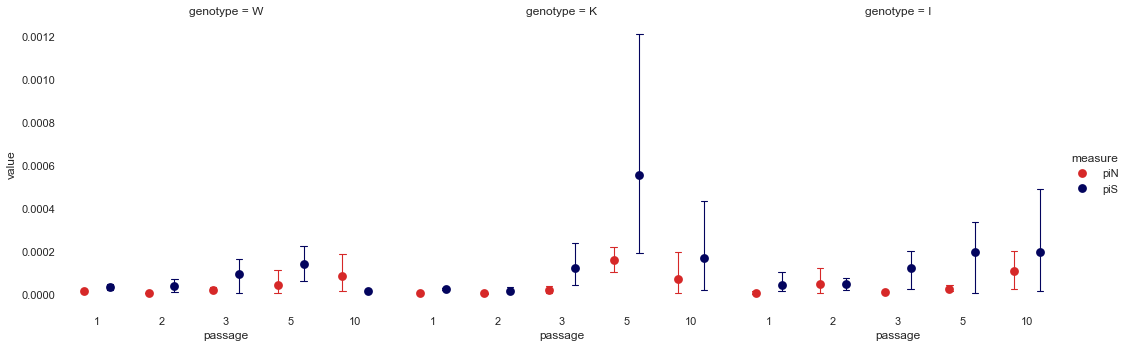

In [99]:
# df_temp --> compare protein 2B 


sns.catplot(
            kind='point',
            data=df_sns[df_sns['protein']=='2B'], 
            col='genotype',
            markers='o', 
            linestyles='',
            x="passage", 
            y='value', 
            hue ='measure', 
            errorbar=('ci', 95),
            hue_order=["piN", "piS"], 
            errwidth=1.1, 
            capsize=0.1,
            palette=['#d62828', '#03045e'],
            dodge=0.4, 
            #log_scale=True, 
        )